In this notebook we will experiment with the AL bias mitigation technique from Richards. 
We will do this on a synthetically biased sample (sample size=700) that we obtained from the CERN dataset, with the rf classifier trained on 10 percent of the data and using a=1/28 and k=0 for the bin distribution

In [ ]:
# Some notes:
# - If you use df.loc[i], you get the instance that had index i in the original dataframe.
# - If you use df.l=iloc[i], you get the ith instance n the current dataframe.

In [221]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import warnings

warnings.filterwarnings(action='ignore')

# Import data

In [222]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [340]:
# df = pd.read_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')
#df=pd.read_csv('CERN_testing_set_30_2000.csv')
#df=pd.read_csv('CERN_testing_set_5_100.csv')
#df=pd.read_csv('CERN_testing_set_50_300.csv')
df=pd.read_csv('CERN_testing_set_300_1000.csv')

In [224]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/dielectron_classification.csv"

df_og= read_file(url)

# Visualize data

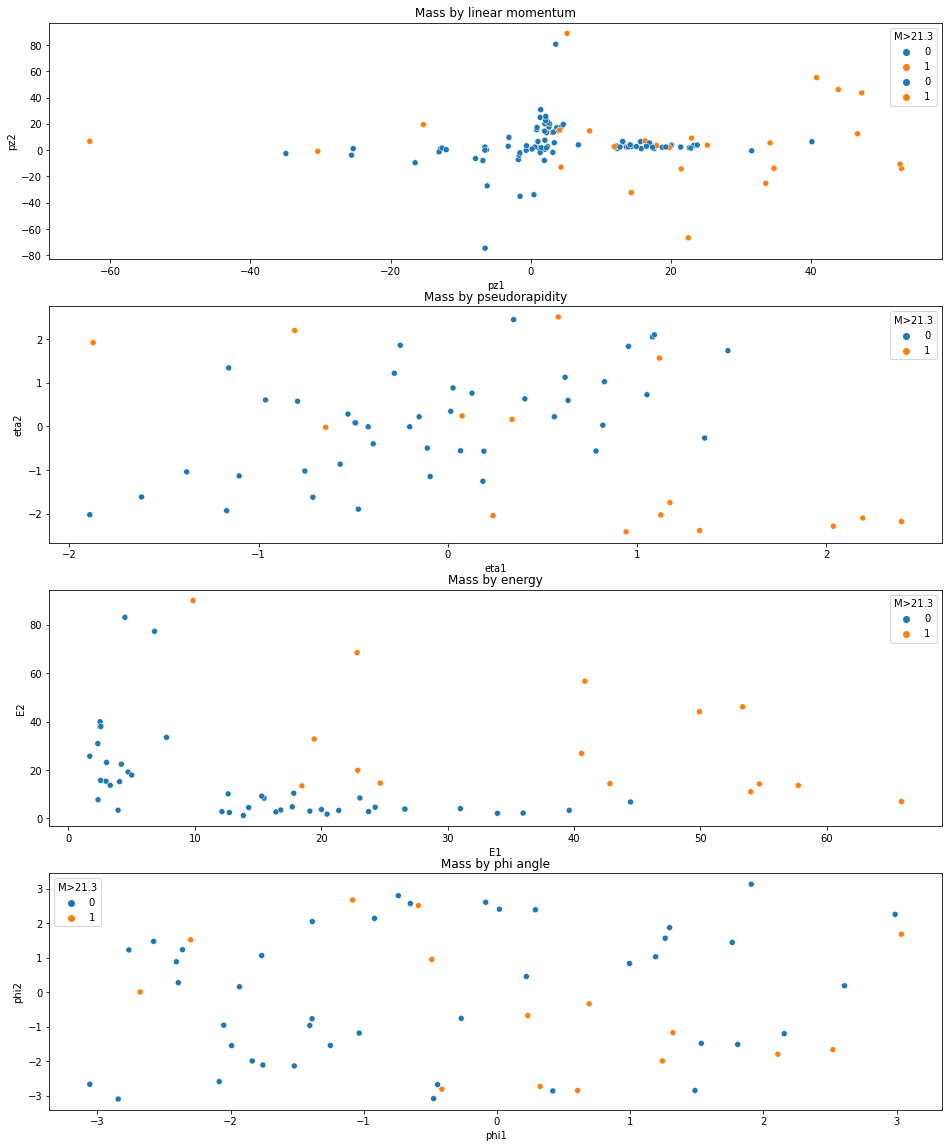

In [133]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_og, x='pz1', y='pz2', hue='M>21.3')
ax[0].set_title('pz1 vs pz2')
sns.scatterplot(ax= ax[0],data=sample_og, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_og, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_og, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_og, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

NameError: name 'sample_700' is not defined

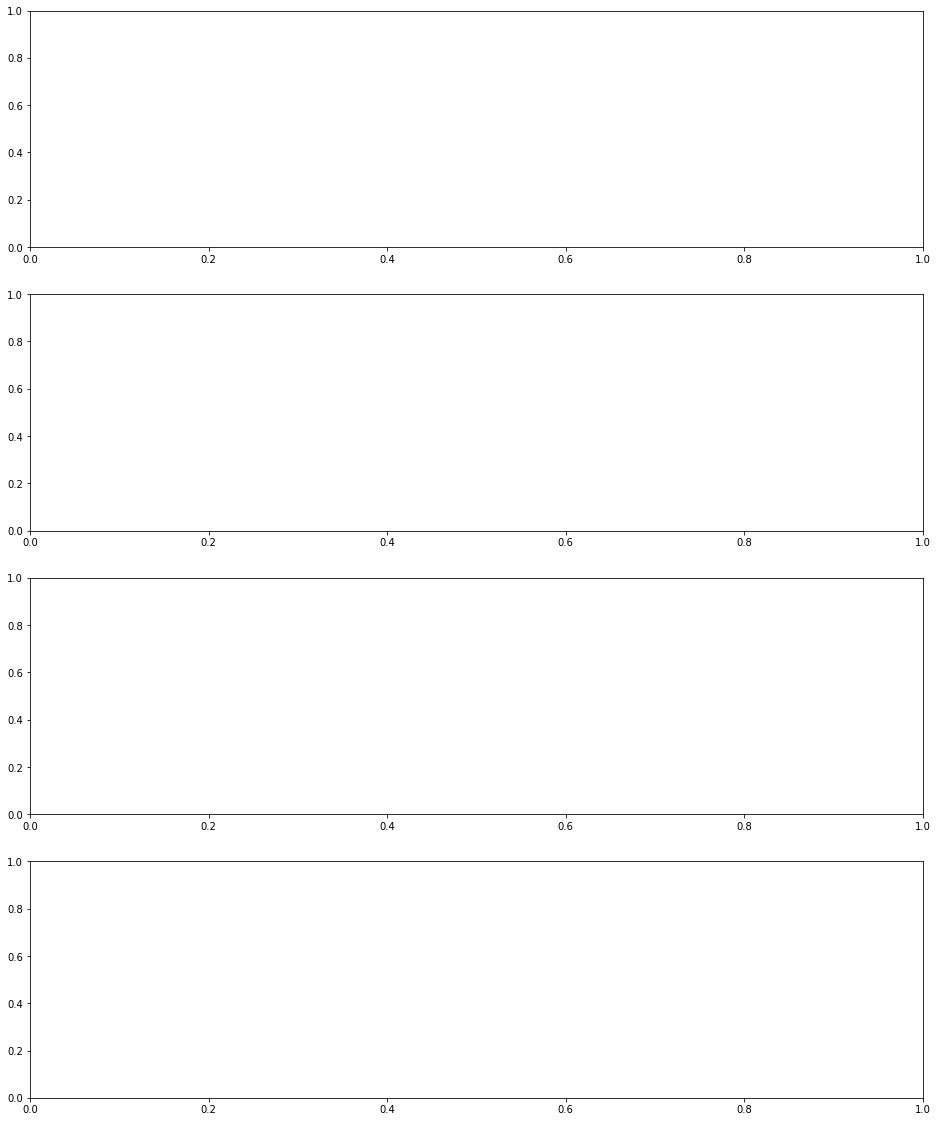

In [6]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_700, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_700, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_700, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_700, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Prep data

In [341]:
# create sample and pool, the sample has size 700
df['s1']=df['pz1']
df['s2']=df['pz2']

sample=df[df['in_biased_sample']==1]
pool=df[df['in_biased_sample']==0]


### Add extra bias

In [297]:
#add noise to s
for i in range(sample.shape[0]):
    sample['s1'].at[i]=sample['s1'][i]+np.random.normal(0,30)
    
#add noise to s
for i in range(sample.shape[0]):
    sample['s2'].at[i]=sample['s2'][i]+np.random.normal(0,30)

In [298]:
sample=sample[(sample['s1'] < 30) & (sample['s1']>-30) & (sample['s2'] < 30) & (sample['s2']>-30)]

In [342]:
sample.shape[0]

300

In [343]:
sample_og=sample
pool_og=pool

In [335]:
sample=sample_og
pool=pool_og

In [344]:
X=df.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y=df.M>21.3
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

In [260]:
X_og=df_og.drop(columns=['M>21.3','M','Run','Event'])
y_og=df_og.M>21.3

## Visualize sample

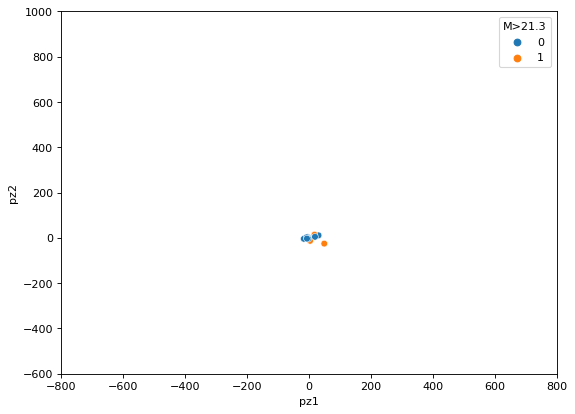

In [49]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=sample, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

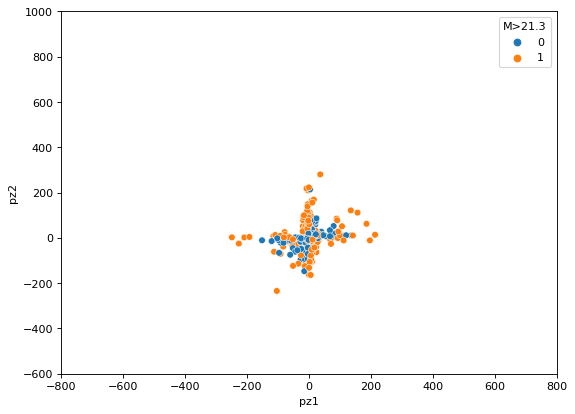

In [10]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=pool, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

# Train rf classifier

In [345]:
#train classifier on sample
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
print ('training time: ', round(time()-t0, 3), 's')

training time:  0.133 s


In [346]:
#accuracy on X (whole set)
t1=time()
pred_rf = rf.predict(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.021 s
Accuracy: 0.8261538461538461


In [347]:
pred_rf = rf.predict(X_og)
print("Accuracy:",metrics.accuracy_score(y_og, pred_rf))

Accuracy: 0.75999


In [80]:
#accuracy on sample
t1=time()
pred_rf_sample = rf.predict(X_sample)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_sample, pred_rf_sample))


predicting time:  0.01 s
Accuracy: 1.0


## Random Forest

In [38]:
##get proximity matrix
def get_proximity_matrix(X, rf):
    
    #find proportion of indices that match between i and j
    #compute the symmetric matrix
    
    n=X.shape[0]
    tree_idxs = rf.apply(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    proximity_matrix = np.empty(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            proximity_matrix[i,j] = np.sum(np.equal(tree_idxs[i,:], tree_idxs[j,:]))
    return proximity_matrix

In [39]:
##get maximum probabilities
def get_max_class_probabilities(X,rf):
    class_probabilities= rf.predict_proba(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    max_class_probabilities=[0]*(len(class_probabilities))
    for i in range (len(class_probabilities)):
        max_class_probabilities[i]=max(class_probabilities[i,0],class_probabilities[i,1])
    return max_class_probabilities

In [17]:
#X=training set, pool=pool of instances to pick from
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
#proximity_matrix=get_proximity_matrix(X+pool,rf)

RandomForestClassifier()

## AL query functions

In [41]:
def get_sum_of_proximities(i1, ys, proximity_matrix):
    proximities=[0]*len(ys)
    for i in range(len(ys)):
        proximities[i]=proximity_matrix[i,i1]
    sum_of_proximities=sum(proximities)
    return sum_of_proximities
        

In [316]:
def s_2(i, proximity_matrix):
    S_2 = get_sum_of_proximities(i, X_pool.index, proximity_matrix)*(1-max_class_probabilities[i])/(get_sum_of_proximities(i, X_sample.index, proximity_matrix)+1)
    return S_2

def uncertainty(i):
    return (1- max_class_probabilities[i])
    
def query_instance (X_sample, X_pool, rf, proximity_matrix, query_mode="s2"):
    max_class_probabilities= get_max_class_probabilities(X, rf)
    #proximity_matrix = get_proximity_matrix(X, rf)
    
    if (query_mode=="s2"):
        s_2_scores=[0]*X_pool.shape[0] 
    else: uncertainty_scores=[0]*X_pool.shape[0]
    
    for i in range(X_pool.shape[0]):
        if (query_mode=="s2"):
            s_2_scores[i]=s_2(int(X_pool.iloc[i].iloc[0]), proximity_matrix)
        else: uncertainty_scores[i]= uncertainty(int(X_pool.iloc[i].iloc[0]))
    if (query_mode=="s2"):
        queried_instance_index = int(X_pool.iloc[np.argmax(s_2_scores)].iloc[0])
    else: queried_instance_index = int(X_pool.iloc[np.argmax(uncertainty_scores)].iloc[0])
    return queried_instance_index

    #what I want to do:
    #get all values of s2 for the instances in the pool in a list
    #get the argmax, which gives the index i with the highest s2 score
    #get the instancce from the pool by using 
    #int(X_sample.iloc[0].iloc[0])

## AL algorithm

In [229]:
#def AL_algorithm(n_of_iterations, X_sample=X_sample, y_sample=y_sample, X_pool=X_pool, y_pool=y_pool, query_mode="s2"):
# initialization of AL algorithm:
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    print ('cp1: ', round(time()-t0, 3), 's')

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy

    #query instance and add to sample
    #if (i<10 | i%10 == 0):
    #    proximity_matrix = get_proximity_matrix(X, rf)
    
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf, query_mode)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)



cp1:  0.113 s


NameError: name 'query_mode' is not defined

## Compare proximity matrix at every iteration vs not

0.63181
0.6196
0.63463
0.64546
0.66209
0.69414
0.6791
0.68803
0.68422
0.69635
0.72313
0.72785
0.74388
0.7389
0.73244
0.74483
0.76524
0.75656
0.77701
0.79535
0.79276
0.80339
0.80955
0.82198
0.83111
0.82745
0.84306
0.83746
0.83581
0.82741
0.62858
0.67795
0.68018
0.7139
0.71092
0.71691
0.73252
0.75202
0.76083
0.76146
0.75757
0.77924
0.77353
0.78329
0.7969
0.80899
0.81841
0.81196
0.81308
0.82678
0.82483
0.82648
0.83195
0.83355
0.82649
0.83886
0.84291
0.8559
0.852
0.84269


Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 67 and pool size 1000')

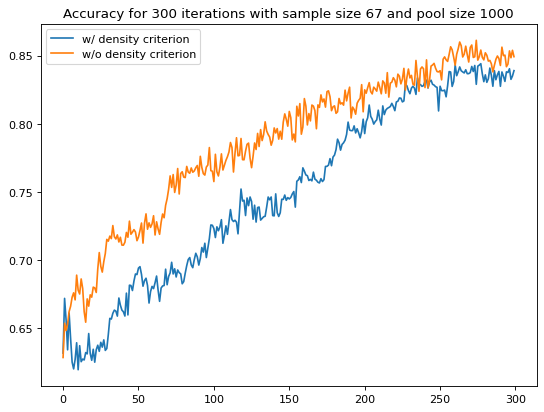

In [332]:
n_of_iterations=300

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm with less calculations of pm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

0.64578
0.64698
0.6679
0.65736
0.68961
0.66989
0.69241
0.7051
0.69789
0.70111
0.71925
0.71509
0.73153
0.73264
0.74105
0.74969
0.75331
0.75723
0.80426
0.79367
0.79516
0.82116
0.82663
0.84024
0.847
0.85297
0.85376
0.86626
0.8639
0.86982
0.64567
0.66831
0.69026
0.69442
0.68257
0.72388
0.73679
0.73431
0.73261
0.73597
0.74284
0.75049
0.76833
0.76681
0.77629
0.77924
0.78569
0.80185
0.79433
0.803
0.80803
0.80783
0.819
0.83117
0.82806
0.82909
0.83446
0.84871
0.84162
0.84467


Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 67 and pool size 1000')

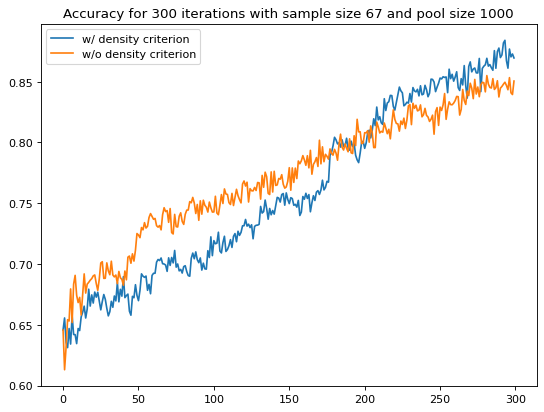

In [328]:
n_of_iterations=300

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm with less calculations of pm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

In [329]:
accuracies_with_density_67_1000=accuracies_with_density
accuracies_without_density_67_1000=accuracies_without_density
queried_instances_with_density_67_1000=queried_instances_with_density
confusion_matrix_with_density_67_DFCrr
1000=confusion_matrix_with_density
final_sample_with_density_67_1000=final_sample_with_density
queried_instances_without_density_67_1000=queried_instances_without_density
confusion_matrix_without_density_67_1000=confusion_matrix_without_density
final_sample_without_density_67_1000=final_sample_without_density

Text(0.5, 1.0, 'Queried Instances with densities')

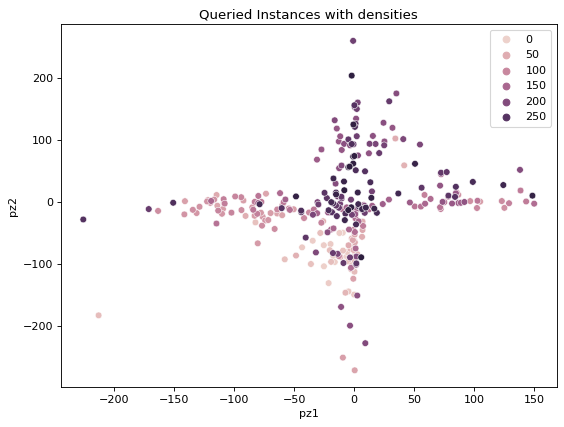

In [333]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_with_density_67_1000], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances with densities")

Text(0.5, 1.0, 'Queried Instances with densities')

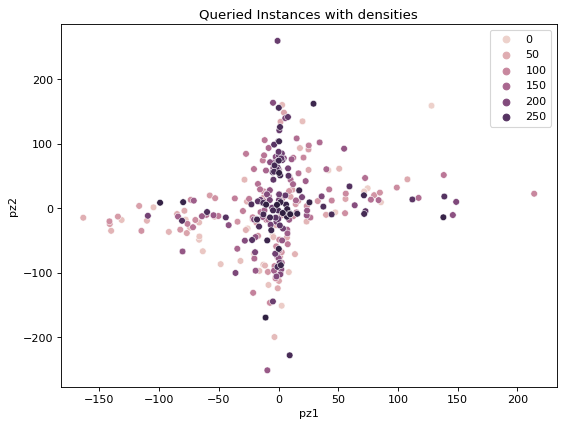

In [334]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_without_density_67_1000], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances with densities")

Text(0.5, 1.0, 'Queried Instances with densities')

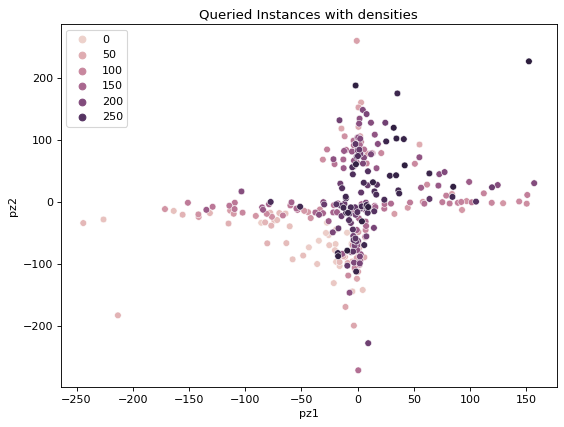

In [318]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_with_density], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances with densities")

Text(0.5, 1.0, 'Queried Instances without densities')

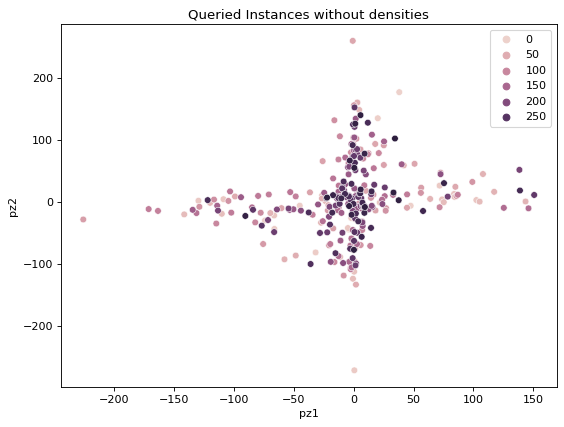

In [319]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_without_density], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances without densities")

In [320]:
accuracies_with_density_67_1000=accuracies_with_density
accuracies_without_density_67_1000=accuracies_without_density
queried_instances_with_density_67_1000=queried_instances_with_density
confusion_matrix_with_density_67_1000=confusion_matrix_with_density
final_sample_with_density_67_1000=final_sample_with_density
queried_instances_without_density_67_1000=queried_instances_without_density
confusion_matrix_without_density_67_1000=confusion_matrix_without_density
final_sample_without_density_67_1000=final_sample_without_density

0 , 0.6369
1 , 0.65254
2 , 0.63824
3 , 0.65007
4 , 0.63752
5 , 0.65305
6 , 0.63709
7 , 0.64116
8 , 0.64767
9 , 0.64139
10 , 0.65468
11 , 0.65026
12 , 0.63499
13 , 0.63667
14 , 0.64091
15 , 0.6434
16 , 0.64223
17 , 0.64059
18 , 0.64582
19 , 0.63409
20 , 0.64372
21 , 0.63668
22 , 0.64882
23 , 0.63487
24 , 0.67076
25 , 0.65968
26 , 0.65375
27 , 0.6687
28 , 0.67022
29 , 0.67352
30 , 0.67755
31 , 0.66859
32 , 0.67413
33 , 0.67617
34 , 0.68251
35 , 0.69317
36 , 0.69013
37 , 0.68506
38 , 0.6867
39 , 0.68502
40 , 0.67282
41 , 0.6855
42 , 0.68227
43 , 0.67813
44 , 0.68266
45 , 0.68986
46 , 0.68044
47 , 0.69211
48 , 0.69292
49 , 0.69561
50 , 0.68225
51 , 0.69931
52 , 0.68834
53 , 0.69142
54 , 0.70033
55 , 0.69499
56 , 0.69707
57 , 0.68992
58 , 0.69312
59 , 0.68192
60 , 0.69885
61 , 0.70091
62 , 0.70129
63 , 0.70759
64 , 0.70599
65 , 0.70935
66 , 0.70561
67 , 0.70632
68 , 0.70531
69 , 0.71031
70 , 0.70532
71 , 0.71472
72 , 0.71642
73 , 0.71456
74 , 0.71922
75 , 0.71605
76 , 0.70218
77 , 0.71139
7

Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 67 and pool size 1000')

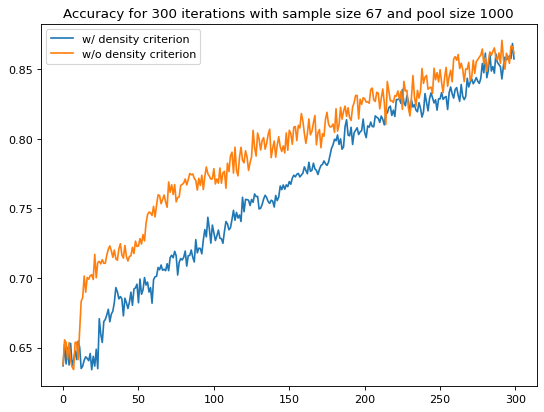

In [305]:
n_of_iterations=300

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm with less calculations of pm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

## Compare SSAL an AL

0.77
0.78659
0.7733
0.77121
0.76098
0.74807
0.74357
0.72827
0.71901
0.70955
0.7035
0.69366
0.67942
0.66889
0.65745
0.6447
0.63476
0.62597
0.61574
0.6026
0.59433
0.59069
0.58539
0.58579
0.58489
0.58597
0.58798
0.58738
0.58307
0.58435
0.58077
0.77464
0.79586
0.78207
0.77172
0.79021
0.80955
0.80335
0.80401
0.82446
0.82382
0.81929
0.82025
0.82221
0.83069
0.83573
0.83787
0.84369
0.83766
0.84142
0.84862
0.84769
0.85184
0.86059
0.86113
0.85637
0.86632
0.85982
0.87038
0.88211
0.87839
0.87501


Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 300 and pool size 1000')

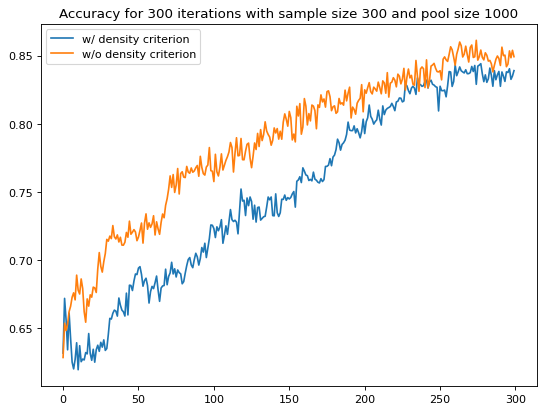

In [348]:
#def compare(n_of_iterations):
n_of_iterations=300

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run SSAL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    #print (i)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    #predicted_label = rf.predict(pd.DataFrame([X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1).loc[n]],axis=0))[0] 
    predicted_label = rf.predict(pd.DataFrame([X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1).loc[n]]))[0]
    y_sample = pd.concat([y_sample, pd.DataFrame([predicted_label])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)

#store stuff
accuracies_SSAL = accuracies
queried_instances_SSAL=queried_instances
confusion_matrix_SSAL=metrics.confusion_matrix(y_og, pred_rf)
final_sample_SSAL=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)


#store stuff
accuracies_AL=accuracies
queried_instances_AL=queried_instances
confusion_matrix_AL=metrics.confusion_matrix(y_og, pred_rf)
final_sample_AL=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 300 and pool size 1000')

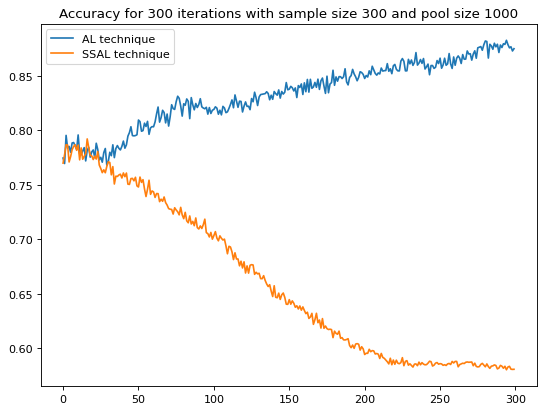

In [350]:
#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_AL, label="AL technique")
plt.plot(accuracies_SSAL, label="SSAL technique")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

0 , 0.73195
1 , 0.72264
2 , 0.73223
3 , 0.72855
4 , 0.74431
5 , 0.74576
6 , 0.74008
7 , 0.75737
8 , 0.74582
9 , 0.74757
10 , 0.74909
11 , 0.74881
12 , 0.73196
13 , 0.74312
14 , 0.74899
15 , 0.74352
16 , 0.75305
17 , 0.74094
18 , 0.74744
19 , 0.73776
20 , 0.73717
21 , 0.72146
22 , 0.74921
23 , 0.73914
24 , 0.7421
25 , 0.7591
26 , 0.744
27 , 0.7449
28 , 0.74348
29 , 0.7519
0.7519
0
0 , 0.69172
1
1 , 0.68129
2
2 , 0.67995
3
3 , 0.68475
4
4 , 0.67156
5
5 , 0.66955
6
6 , 0.66181
7
7 , 0.654
8
8 , 0.65529
9
9 , 0.63901
10
10 , 0.64893
11
11 , 0.65134
12
12 , 0.64245
13
13 , 0.64146
14
14 , 0.63137
15
15 , 0.64563
16
16 , 0.62893
17
17 , 0.63105
18
18 , 0.6222
19
19 , 0.62477
20
20 , 0.61437
21
21 , 0.61538
22
22 , 0.61783
23
23 , 0.61571
24
24 , 0.61729
25
25 , 0.61315
26
26 , 0.60272
27
27 , 0.60062
28
28 , 0.61264
29
29 , 0.60402
0.60402


Text(0.5, 1.0, 'Accuracy for 30 iterations with sample size 50 and pool size 300')

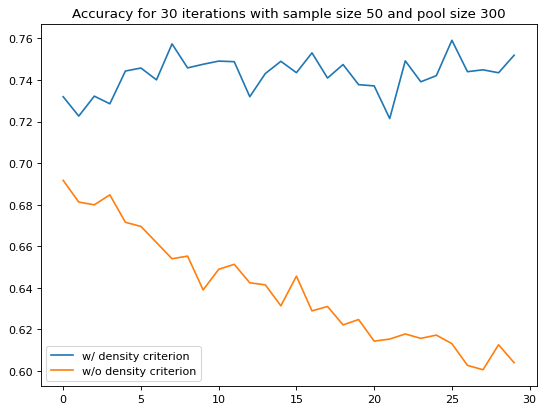

In [278]:
#def compare(n_of_iterations):
n_of_iterations=30

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run SSAL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    print (i)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    #predicted_label = rf.predict(pd.DataFrame([X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1).loc[n]],axis=0))[0] 
    predicted_label = rf.predict(pd.DataFrame([X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1).loc[n]]))[0]
    y_sample = pd.concat([y_sample, pd.DataFrame([predicted_label])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

In [266]:
print(accuracies)

[0.50081, 0.50159, 0.50106, 0.50083, 0.50083, 0.50082, 0.50082, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081, 0.50081]


In [247]:
rf.predict(pd.DataFrame([X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1).loc[0]]))[0]

False

## Compare with/without density criterium

cp1:  0.093 s
cp1:  1.167 s
cp1:  2.366 s
cp1:  3.471 s
cp1:  4.566 s
cp1:  5.679 s
cp1:  6.778 s
cp1:  7.887 s
cp1:  8.997 s
cp1:  10.129 s
cp1:  11.27 s
cp1:  12.451 s
cp1:  13.656 s
cp1:  14.811 s
cp1:  15.981 s
cp1:  17.282 s
cp1:  18.475 s
cp1:  19.625 s
cp1:  20.794 s
cp1:  21.951 s
cp1:  23.067 s
cp1:  24.214 s
cp1:  25.435 s
cp1:  26.674 s
cp1:  27.895 s
cp1:  29.106 s
cp1:  30.324 s
cp1:  31.484 s
cp1:  32.627 s
cp1:  33.757 s
cp1:  34.896 s
cp1:  36.051 s
cp1:  37.193 s
cp1:  38.342 s
cp1:  39.497 s
cp1:  40.657 s
cp1:  41.817 s
cp1:  42.974 s
cp1:  44.135 s
cp1:  45.298 s
cp1:  46.674 s
cp1:  48.158 s
cp1:  49.706 s
cp1:  51.22 s
cp1:  52.591 s
cp1:  54.054 s
cp1:  55.633 s
cp1:  57.146 s
cp1:  58.551 s
cp1:  59.911 s
cp1:  61.27 s
cp1:  62.596 s
cp1:  63.996 s
cp1:  65.375 s
cp1:  66.698 s
cp1:  68.027 s
cp1:  69.381 s
cp1:  70.571 s
cp1:  71.764 s
cp1:  72.936 s
cp1:  74.107 s
cp1:  75.285 s
cp1:  76.489 s
cp1:  77.686 s
cp1:  78.904 s
cp1:  80.087 s
cp1:  81.395 s
cp1:  8

Text(0.5, 1.0, 'Accuracy for 200 iterations with sample size 12 and pool size 300')

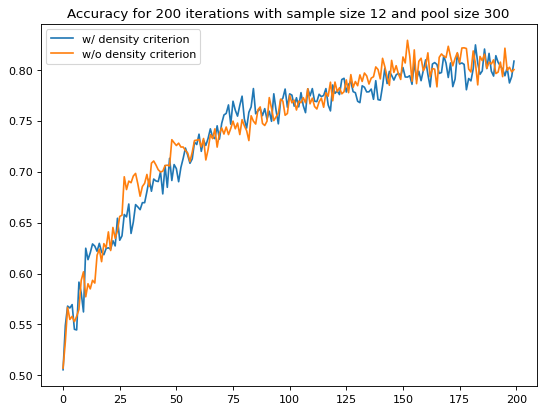

In [218]:
#def compare(n_of_iterations):
n_of_iterations=100

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run algorithm with density
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    print ('cp1: ', round(time()-t0, 3), 's')

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run algorithm w/o density
#run algorithm with density
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    print ('cp1: ', round(time()-t0, 3), 's')

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

In [227]:
accuracies_with_density_12_300=accuracies_with_density
accuracies_without_density_12_300=accuracies_without_density
queried_instances_with_density_12_300=queried_instances_with_density
confusion_matrix_with_density_12_300=confusion_matrix_with_density
final_sample_with_density_12_300=final_sample_with_density
queried_instances_without_density_12_300=queried_instances_without_density
confusion_matrix_without_density_12_300=confusion_matrix_without_density
final_sample_without_density_12_300=final_sample_without_density

In [203]:
accuracies=[0]*5

## Results for sample size =12, pool size=300

In [119]:
accuracies_with_density=accuracies

In [120]:
queried_instances_with_density=queried_instances

In [122]:
metrics_with_density=metrics.classification_report(y_og, pred_rf)

In [123]:
print(metrics_with_density)

              precision    recall  f1-score   support

       False       0.82      0.82      0.82     50080
        True       0.82      0.82      0.82     49920

    accuracy                           0.82    100000
   macro avg       0.82      0.82      0.82    100000
weighted avg       0.82      0.82      0.82    100000



In [132]:
accuracies_without_density=accuracies

In [133]:
queried_instances_without_density=queried_instances

In [134]:
metrics_without_density=metrics.classification_report(y_og, pred_rf)

In [136]:
print(metrics_without_density)

              precision    recall  f1-score   support

       False       0.81      0.81      0.81     50080
        True       0.81      0.81      0.81     49920

    accuracy                           0.81    100000
   macro avg       0.81      0.81      0.81    100000
weighted avg       0.81      0.81      0.81    100000



Text(0.5, 1.0, 'Accuracy for 200 iterations with sample size 12 and pool size 300')

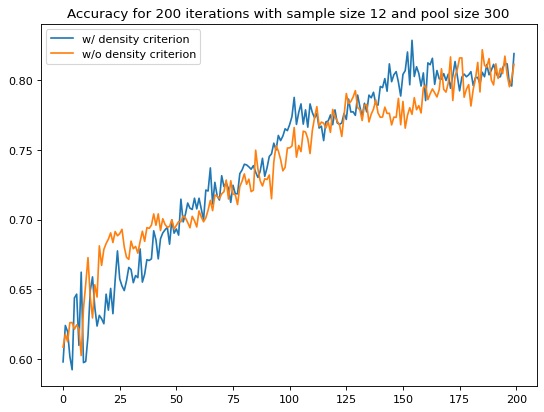

In [141]:
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for 200 iterations with sample size 12 and pool size 300")

### Queried instances

Text(0.5, 1.0, 'Queried Instances with density')

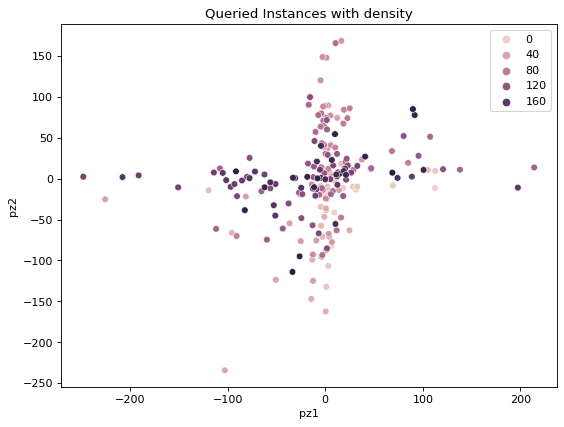

In [137]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_with_density], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances with density")

Text(0.5, 1.0, 'Queried Instances without density')

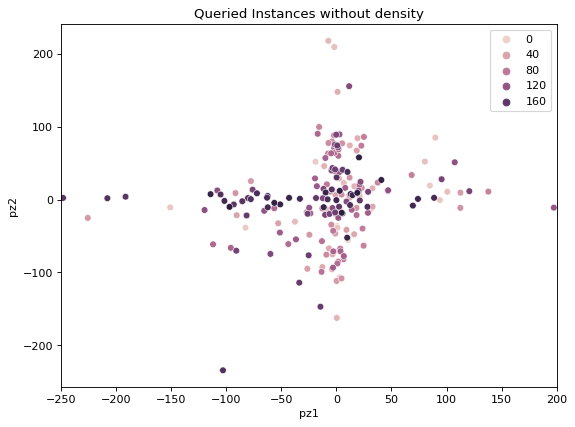

In [138]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances_without_density], x='pz1', y='pz2', hue=range(len(queried_instances)))
plt.xlim([ -250,200])
ax = plt.gca()
ax.set_title("Queried Instances without density")